In [1]:
%%capture
!pip install langgraph
!pip install langchain_openai
!pip install langchain_core
!pip install pygraphviz


In [2]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz --no-binary=pygraphviz --force-reinstall


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.
  Using cached pygraphviz-1.14-cp312-cp312-linux_x86_64.whl
  Attempting uninstall: pygraphviz
    Found existing installation: pygraphviz 1.14
    Uninstalling pygraphviz-1.14:
      Successfully uninstalled pygraphviz-1.14


In [3]:
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
import operator
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Image
from pprint import pprint
from google.colab import userdata



In [18]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7, api_key=userdata.get('OPENAI_API_KEY'))

In [5]:
class ChainState(TypedDict):
    job_description: str
    resume_summary: str
    cover_letter: str

In [6]:
def generate_resume_summary(state: ChainState) -> ChainState:
    prompt = f"""
You're a resume assistant. Read the following job description and summarize the key qualifications and experience the ideal candidate should have, phrased as if from the perspective of a strong applicant's resume summary.

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "resume_summary": response.content}

In [7]:
def generate_cover_letter(state: ChainState) -> ChainState:
    prompt = f"""
You're a cover letter writing assistant. Using the resume summary below, write a professional and personalized cover letter for the following job.

Resume Summary:
{state['resume_summary']}

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "cover_letter": response.content}

In [8]:
workflow = StateGraph(ChainState)
workflow

In [9]:
workflow.add_node("generate_resume_summary", generate_resume_summary)
workflow.add_node("generate_cover_letter", generate_cover_letter)

In [10]:
workflow.set_entry_point("generate_resume_summary")

In [11]:
workflow.add_edge("generate_resume_summary", "generate_cover_letter")

In [12]:
workflow.set_finish_point("generate_cover_letter")

In [13]:
def print_workflow_info(workflow, app=None):
    """Prints comprehensive information about a LangGraph workflow."""
    print("WORKFLOW INFORMATION")
    print("====================")
    print(f"Nodes: {workflow.nodes}")
    print(f"Edges: {workflow.edges}")


    # Use getter method for finish points if available
    try:
        finish_points = workflow.finish_points
        print(f"Finish points: {finish_points}")
    except:
        try:
            # Alternative approaches
            print(f"Finish point: {workflow._finish_point}")
        except:
            print("Finish points attribute not directly accessible")

    if app:
        print("\nWorkflow Visualization:")
        from IPython.display import display
        display(app.get_graph().draw_png())

In [14]:
print_workflow_info(workflow)

WORKFLOW INFORMATION
Nodes: {'generate_resume_summary': StateNodeSpec(runnable=generate_resume_summary(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.ChainState'>, retry_policy=None, cache_policy=None, ends=(), defer=False), 'generate_cover_letter': StateNodeSpec(runnable=generate_cover_letter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.ChainState'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}
Edges: {('__start__', 'generate_resume_summary'), ('generate_cover_letter', '__end__'), ('generate_resume_summary', 'generate_cover_letter')}
Finish points attribute not directly accessible


In [15]:
app = workflow.compile()

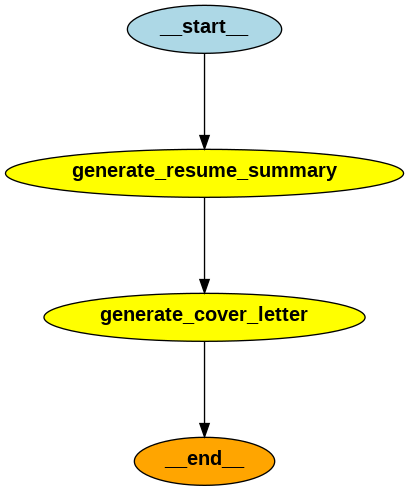

In [16]:
# Generate a visualization of the workflow graph
display(Image(app.get_graph().draw_png()))

In [19]:
input_state = {
        "job_description": "We are looking for a data scientist with experience in machine learning, NLP, and Python. Prior work with large datasets and experience deploying models into production is required."
}

result = app.invoke(input_state)

In [20]:
result['resume_summary']

'**Resume Summary:**\n\nResults-driven Data Scientist with extensive experience in machine learning and natural language processing (NLP), proficient in Python programming. Demonstrated expertise in handling large datasets and deploying robust models into production environments. Proven ability to leverage advanced analytical skills to derive actionable insights and drive data-driven decision-making. Committed to continuous learning and staying current with emerging technologies in the data science field.'

In [21]:
result['job_description']

'We are looking for a data scientist with experience in machine learning, NLP, and Python. Prior work with large datasets and experience deploying models into production is required.'

In [22]:
result['cover_letter']

"[Your Name]  \n[Your Address]  \n[City, State, Zip]  \n[Your Email]  \n[Your Phone Number]  \n[Date]  \n\n[Employer's Name]  \n[Company's Name]  \n[Company's Address]  \n[City, State, Zip]  \n\nDear [Employer's Name],\n\nI am writing to express my interest in the Data Scientist position at [Company's Name] as advertised. With a strong background in machine learning, natural language processing (NLP), and Python programming, coupled with my experience in handling large datasets and deploying models into production, I am excited about the opportunity to contribute to your team.\n\nThroughout my career, I have focused on leveraging data to drive strategic decision-making. My hands-on experience with machine learning algorithms has enabled me to build and deploy robust models that address complex business challenges. At [Previous Company Name], I successfully led a project where I developed an NLP-driven application that significantly improved customer sentiment analysis, resulting in a 2